# Trace simulator experiments

This is a trace simulator.

1. We first start creating a NUMBER_OF_TOWERS towers in a random distribution.
2. Then we generate random traces for NUMBER_OF_USERS users through a number of CYCLES.
3. Finally we aggregate the data, the number of users for each tower in each cycle.

To generate random traces we take into account the distances between the towers and the cycle number (a.k.a. hours)

In [1]:
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Constants

In [2]:
NUMBER_OF_TOWERS = 100
NUMBER_OF_USERS = 1000
CYCLES = 24

#
# The probability of jumping to another tower when its
# distance is within one of these distance percentiles.
#
PERCENTILES_PROB = [
    (0.05, 0.75),
    (0.15, 0.125),
    (0.30, 0.09375),
    (1.00, 0.03125),
]

### Generator utils

In [3]:
def distance(p1, p2):
    """Distance between two points"""
    return math.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))

def get_random_trace(distances):
    """Generates an array of length CYCLES
    
    Each element of the returned array represents a tower of a user's trace
    """
    towers_ids = np.arange(NUMBER_OF_TOWERS)
    
    trace = []
    for cycle in range(CYCLES):
        if cycle == 0:
            # For the first towers the chance of selecting a tower is equally distributed
            trace.append(np.random.choice(towers_ids))
        else:
            #
            # For the next tower, the probability changes depending on the distance between
            # the last tower and the others.
            #
            # Also, we take into account the cycle number, so there's always a probability of
            # switching towers or not.
            #
            last_tower = trace[cycle - 1]
            
            # Night vs. Not-night probabilities
            switch_tower_prob = [0.2, 0.8] if cycle in range(0, 7) else [0.5, 0.5]

            if np.random.choice([True, False], p=switch_tower_prob):
                #
                # Get distances of last tower to the rest and
                # prevents the same last_tower from being selected
                #
                last_tower_dist = distances[last_tower].drop(last_tower)

                # Define the distances quantiles for the percentiles defined in the settings
                dist_quantiles = np.array([last_tower_dist.quantile(p) for p, _ in PERCENTILES_PROB])

                # For each distance, determine in which quantile that distance fits
                towers_prob = np.array([
                    PERCENTILES_PROB[np.argmin(d >= dist_quantiles + 0.00001)][1]
                    for d in last_tower_dist
                ])

                #
                # Equally divide the percentile probability
                # by the number of towers that fit in that group.
                #
                # For example, if 5 towers fit in the first percentile (top 5%), and the probability
                # for that group is of 0.25, then each tower has a 0.05 (= 0.25 / 5) chance of
                # being the following tower.
                #
                prob_items, prob_items_counts = np.unique(towers_prob, return_counts=True)
                for prob_item, prob_item_count in zip(prob_items, prob_items_counts):
                    towers_prob[towers_prob == prob_item] /= prob_item_count

                # Select a random tower taking into account the probabilities
                possible_towers_ids = distances.index.drop(last_tower)
                trace.append(np.random.choice(possible_towers_ids, p=towers_prob))
            else:
                trace.append(last_tower)
    
    return trace

def generate_user_traces(distances):
    return np.array([get_random_trace(distances) for _ in range(NUMBER_OF_USERS)])

def generate_aggregate_data(traces):
    """Returns how many users were in each step of the cycle based on traces"""
    output = np.zeros((NUMBER_OF_TOWERS, CYCLES))
    for tower in range(NUMBER_OF_TOWERS):
        for user in range(NUMBER_OF_USERS):
            for time in range(CYCLES):
                output[tower][time] += traces[user][time] == tower
    return output

### Generate towers with random positions

In [4]:
towers = np.random.rand(NUMBER_OF_TOWERS, 2)

In [5]:
towers.shape

(100, 2)

### Plot towers positions

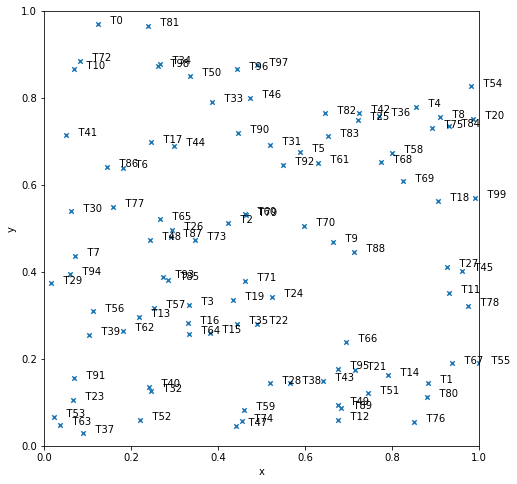

In [6]:
df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(8, 8), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

plt.gca().set_aspect('equal', adjustable='box')

### Calculate the distances between towers for each tower

In [7]:
distances = pd.DataFrame([
    [distance(towers[i], towers[j]) for j in range(NUMBER_OF_TOWERS)] for i in range(NUMBER_OF_TOWERS)
])

### Show example of tower distance probabilities

Distance quantiles: [0.11746424 0.24422993 0.45527661 1.09864514]


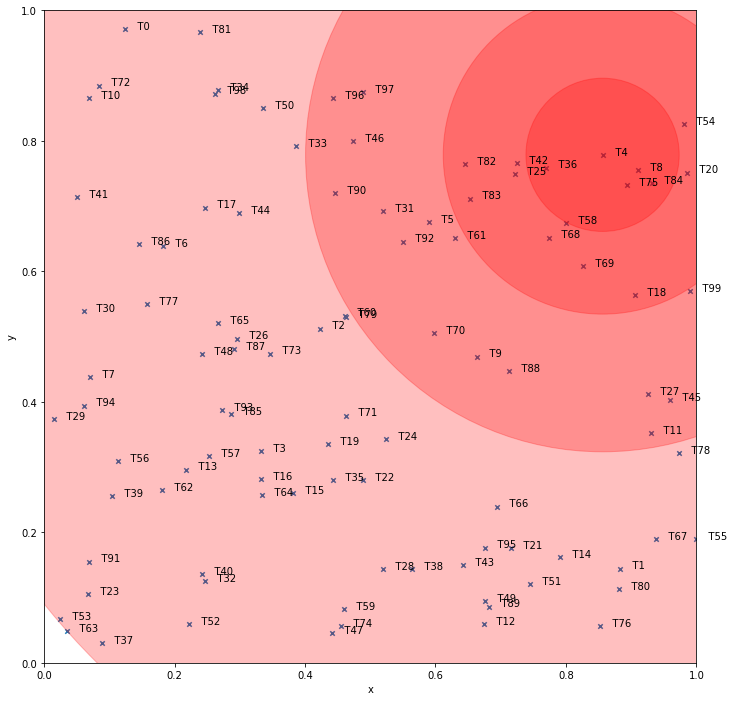

In [8]:
tower_id = 4
tower_dists = distances[tower_id]
dist_quantiles = np.array([tower_dists.quantile(p) for p, _ in PERCENTILES_PROB])
print('Distance quantiles:', dist_quantiles)

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

for r in dist_quantiles:
    ax.add_artist(plt.Circle(towers[tower_id], r, color='r', alpha=1.0 / len(dist_quantiles)))
    
plt.gca().set_aspect('equal', adjustable='box')

## Generate random user traces

We take into account the distances between towers in order to select the following towers

In [9]:
%time random_traces = generate_user_traces(distances)

CPU times: user 19.2 s, sys: 41 ms, total: 19.2 s
Wall time: 19.2 s


In [10]:
%time aggregated_data = generate_aggregate_data(random_traces)

print(f'Traces shape: {random_traces.shape}\t aggregated_data shape: {aggregated_data.shape}')

CPU times: user 8.38 s, sys: 13.6 ms, total: 8.39 s
Wall time: 8.4 s
Traces shape: (1000, 24)	 aggregated_data shape: (100, 24)


In [11]:
random_traces

array([[52, 91, 35, ..., 95, 51, 51],
       [20, 20, 20, ...,  1, 76, 24],
       [53, 53, 53, ..., 73, 10, 10],
       ...,
       [51, 51, 51, ...,  3, 85, 57],
       [60, 44, 44, ..., 37, 63, 63],
       [ 0,  0,  0, ..., 98, 98, 98]])

In [12]:
aggregated_data

array([[11.,  8.,  6., ...,  2.,  3.,  4.],
       [ 5.,  7., 11., ...,  6.,  6.,  4.],
       [12., 15., 10., ..., 13., 10., 17.],
       ...,
       [ 6.,  4.,  5., ...,  7., 10., 10.],
       [ 9.,  5.,  5., ..., 12., 10.,  8.],
       [13., 11., 11., ...,  7.,  5.,  7.]])

In [13]:
# Check that the sum of users at every cycle is the same
all(aggregated_data.sum(axis=0) == NUMBER_OF_USERS)

True

In [14]:
random_traces[8]

array([88, 88, 88, 88, 88,  9,  9, 70, 70, 70, 70, 70, 70,  9, 21, 66, 21,
       21, 21, 21, 45, 18, 18, 58])

## Draw some random user traces

Cycle #0: Skipping
Cycle #1: Plotting from T76 to T1
Cycle #2: Skipping
Cycle #3: Skipping
Cycle #4: Skipping
Cycle #5: Skipping
Cycle #6: Skipping
Cycle #7: Plotting from T1 to T67
Cycle #8: Skipping
Cycle #9: Skipping
Cycle #10: Plotting from T67 to T18
Cycle #11: Skipping
Cycle #12: Skipping
Cycle #13: Plotting from T18 to T58
Cycle #14: Plotting from T58 to T75
Cycle #15: Plotting from T75 to T20
Cycle #16: Skipping
Cycle #17: Skipping
Cycle #18: Plotting from T20 to T25
Cycle #19: Skipping
Cycle #20: Skipping
Cycle #21: Skipping
Cycle #22: Plotting from T25 to T83


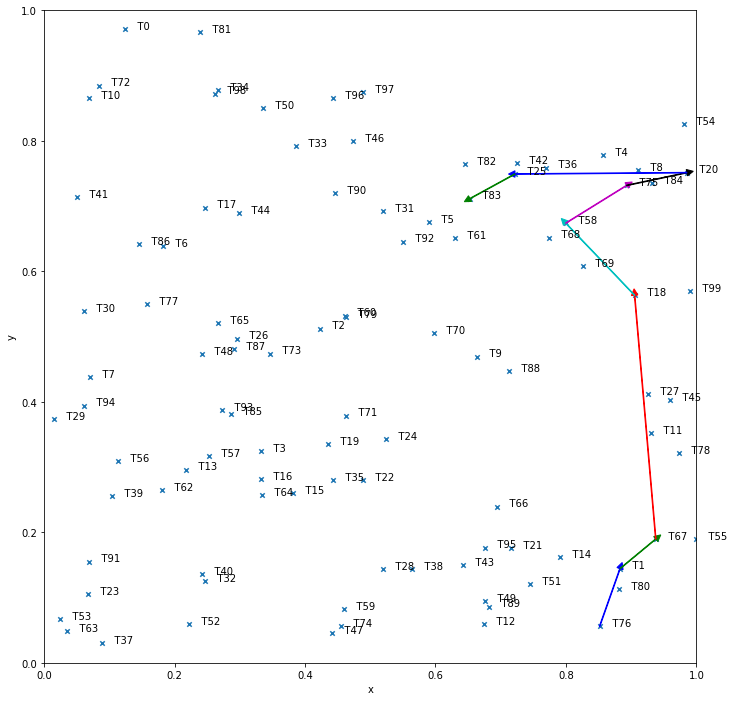

In [21]:
from itertools import cycle

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

cycol = cycle('bgrcmk')

trace = random_traces[6]
for i in range(CYCLES - 1):
    if trace[i] == trace[i + 1]:
        print(f'Cycle #{i}: Skipping')
        continue
    x1, y1 = towers[trace[i]]
    x2, y2 = towers[trace[i + 1]]

    print(f'Cycle #{i}: Plotting from T{trace[i]} to T{trace[i + 1]}')
    color = next(cycol)
    ax.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.01, head_length=0.01, fc=color, ec=color)

plt.gca().set_aspect('equal', adjustable='box')